# Import Library

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
np.set_printoptions(precision=2)
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)
import optuna

# Data Preview

In [72]:
X_train = pd.read_csv("train_features.csv")
y_train = pd.read_csv("train_labels.csv")
X_test = pd.read_csv("test_features.csv")
submission_format = pd.read_csv("submission_format.csv")

X_test = X_test.drop(["ID"], axis=1)

In [73]:
X_train.head()

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
0,1979,Sarjana,Rencana Menikah,NaN,0.0,1.0,NaN,50575.0,260967.0,50575.0,20230.0,2.0,2.0,5.0,0.0,2014-05-05
1,1950,Sarjana,Rencana Menikah,84063000.0,NaN,NaN,70.0,6069.0,44506.0,80920.0,20230.0,9.0,6.0,4.0,0.0,2013-03-17
2,1966,Sarjana,Menikah,127532564.0,0.0,0.0,45.0,117611.0,265460.0,96341.0,145573.0,1.0,1.0,7.0,0.0,NaN
3,1961,Magister,Rencana Menikah,165579620.0,0.0,0.0,90.0,206346.0,1613901.0,27725.0,125868.0,0.0,7.0,8.0,0.0,NaN
4,1970,Sarjana,Rencana Menikah,117703159.0,1.0,1.0,78.0,90563.0,311757.0,40358.0,33875.0,7.0,6.0,5.0,0.0,NaN


In [74]:
y_train.head()

,jumlah_promosi
0,2
1,0
2,1
3,4
4,4


In [75]:
X_test.head()

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
0,1957,Sarjana,NaN,120660151.0,0.0,1.0,63.0,122277.0,541399.0,214192.0,84305.0,4.0,6.0,10.0,0.0,NaN
1,1968,Doktor,Menikah,163551821.0,0.0,1.0,58.0,35761.0,353335.0,63365.0,41112.0,2.0,5.0,10.0,0.0,NaN
2,1968,SMA,Menikah,29857000.0,0.0,0.0,34.0,8092.0,22253.0,30345.0,26299.0,2.0,0.0,5.0,0.0,2013-08-06
3,1971,Doktor,Menikah,117949098.0,0.0,1.0,82.0,4872.0,126061.0,0.0,9745.0,3.0,5.0,7.0,0.0,NaN
4,1974,Sarjana,Rencana Menikah,164761134.0,0.0,0.0,28.0,343208.0,1416462.0,236196.0,107776.0,0.0,1.0,8.0,0.0,NaN


In [76]:
train = pd.concat([X_train, y_train], axis=1)

In [77]:
train.shape

(3817, 17)

# Data Understanding

In [78]:
def summary(df):
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['Duplicate'] = df.duplicated().sum()
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['avg'] = desc['mean'].values
    summ['std dev'] = desc['std'].values
    # summ['top value'] = desc['top'].values
    # summ['Freq'] = desc['freq'].values

    return summ

In [79]:
summary(X_train).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
tahun_kelahiran,int64,0,0,76,1899.000000,2000.000000,1967.823946,11.768131
pendidikan,object,189,0,6,nan,nan,nan,nan
status_pernikahan,object,212,0,6,nan,nan,nan,nan
pendapatan,float64,190,0,3622,5073000.000000,332884000.000000,114483170.089606,43460423.969516
jumlah_anak_balita,float64,190,0,3,0.000000,2.000000,0.293080,0.473063
jumlah_anak_remaja,float64,204,0,3,0.000000,2.000000,0.353723,0.493014
terakhir_belanja,float64,172,0,113,0.000000,128.000000,47.231550,27.068512
belanja_buah,float64,181,0,2535,0.000000,396508.000000,59804.239824,74024.976109
belanja_daging,float64,178,0,2951,0.000000,3489675.000000,438574.823853,512042.740059
belanja_ikan,float64,193,0,2627,0.000000,621600.000000,81428.997792,99976.226855


In [80]:
summary(X_test).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
tahun_kelahiran,int64,0,0,85,1892.000000,2009.000000,1967.789942,11.808572
pendidikan,object,204,0,6,nan,nan,nan,nan
status_pernikahan,object,182,0,6,nan,nan,nan,nan
pendapatan,float64,203,0,3610,2998899.000000,1305740000.000000,116324904.534716,51051222.459486
jumlah_anak_balita,float64,209,0,3,0.000000,2.000000,0.282904,0.465005
jumlah_anak_remaja,float64,210,0,3,0.000000,2.000000,0.355322,0.496865
terakhir_belanja,float64,201,0,116,0.000000,133.000000,47.181366,26.940287
belanja_buah,float64,186,0,2573,0.000000,408646.000000,61234.083425,76647.590617
belanja_daging,float64,195,0,2943,0.000000,3271191.000000,452848.379796,512320.643716
belanja_ikan,float64,196,0,2660,0.000000,574932.000000,85338.612093,103789.546199


In [81]:
for column in X_train.columns:
    print(X_train[column].value_counts())

tahun_kelahiran
1968    140
1970    137
1969    134
1972    130
1973    125
       ... 
1998      1
1916      1
1912      1
1925      1
1908      1
Name: count, Length: 76, dtype: int64
pendidikan
Sarjana     1841
Magister     856
SMA          435
Doktor       403
SMP           91
5              2
Name: count, dtype: int64
status_pernikahan
Rencana Menikah    1271
Menikah            1114
Sendiri             965
Cerai               214
Cerai Mati           40
5                     1
Name: count, dtype: int64
pendapatan
58555000.0     2
98033000.0     2
100016000.0    2
102971000.0    2
147845000.0    2
              ..
75153084.0     1
43279588.0     1
263538206.0    1
112547078.0    1
130512000.0    1
Name: count, Length: 3622, dtype: int64
jumlah_anak_balita
0.0    2594
1.0    1003
2.0      30
Name: count, dtype: int64
jumlah_anak_remaja
0.0    2361
1.0    1226
2.0      26
Name: count, dtype: int64
terakhir_belanja
48.0     57
39.0     55
23.0     53
27.0     52
25.0     50
         .

# Data Preprocessing

In [82]:
# train = pd.get_dummies(train, columns=['pendidikan', 'status_pernikahan'])
train = train.drop(['pendidikan', 'status_pernikahan'], axis=1)


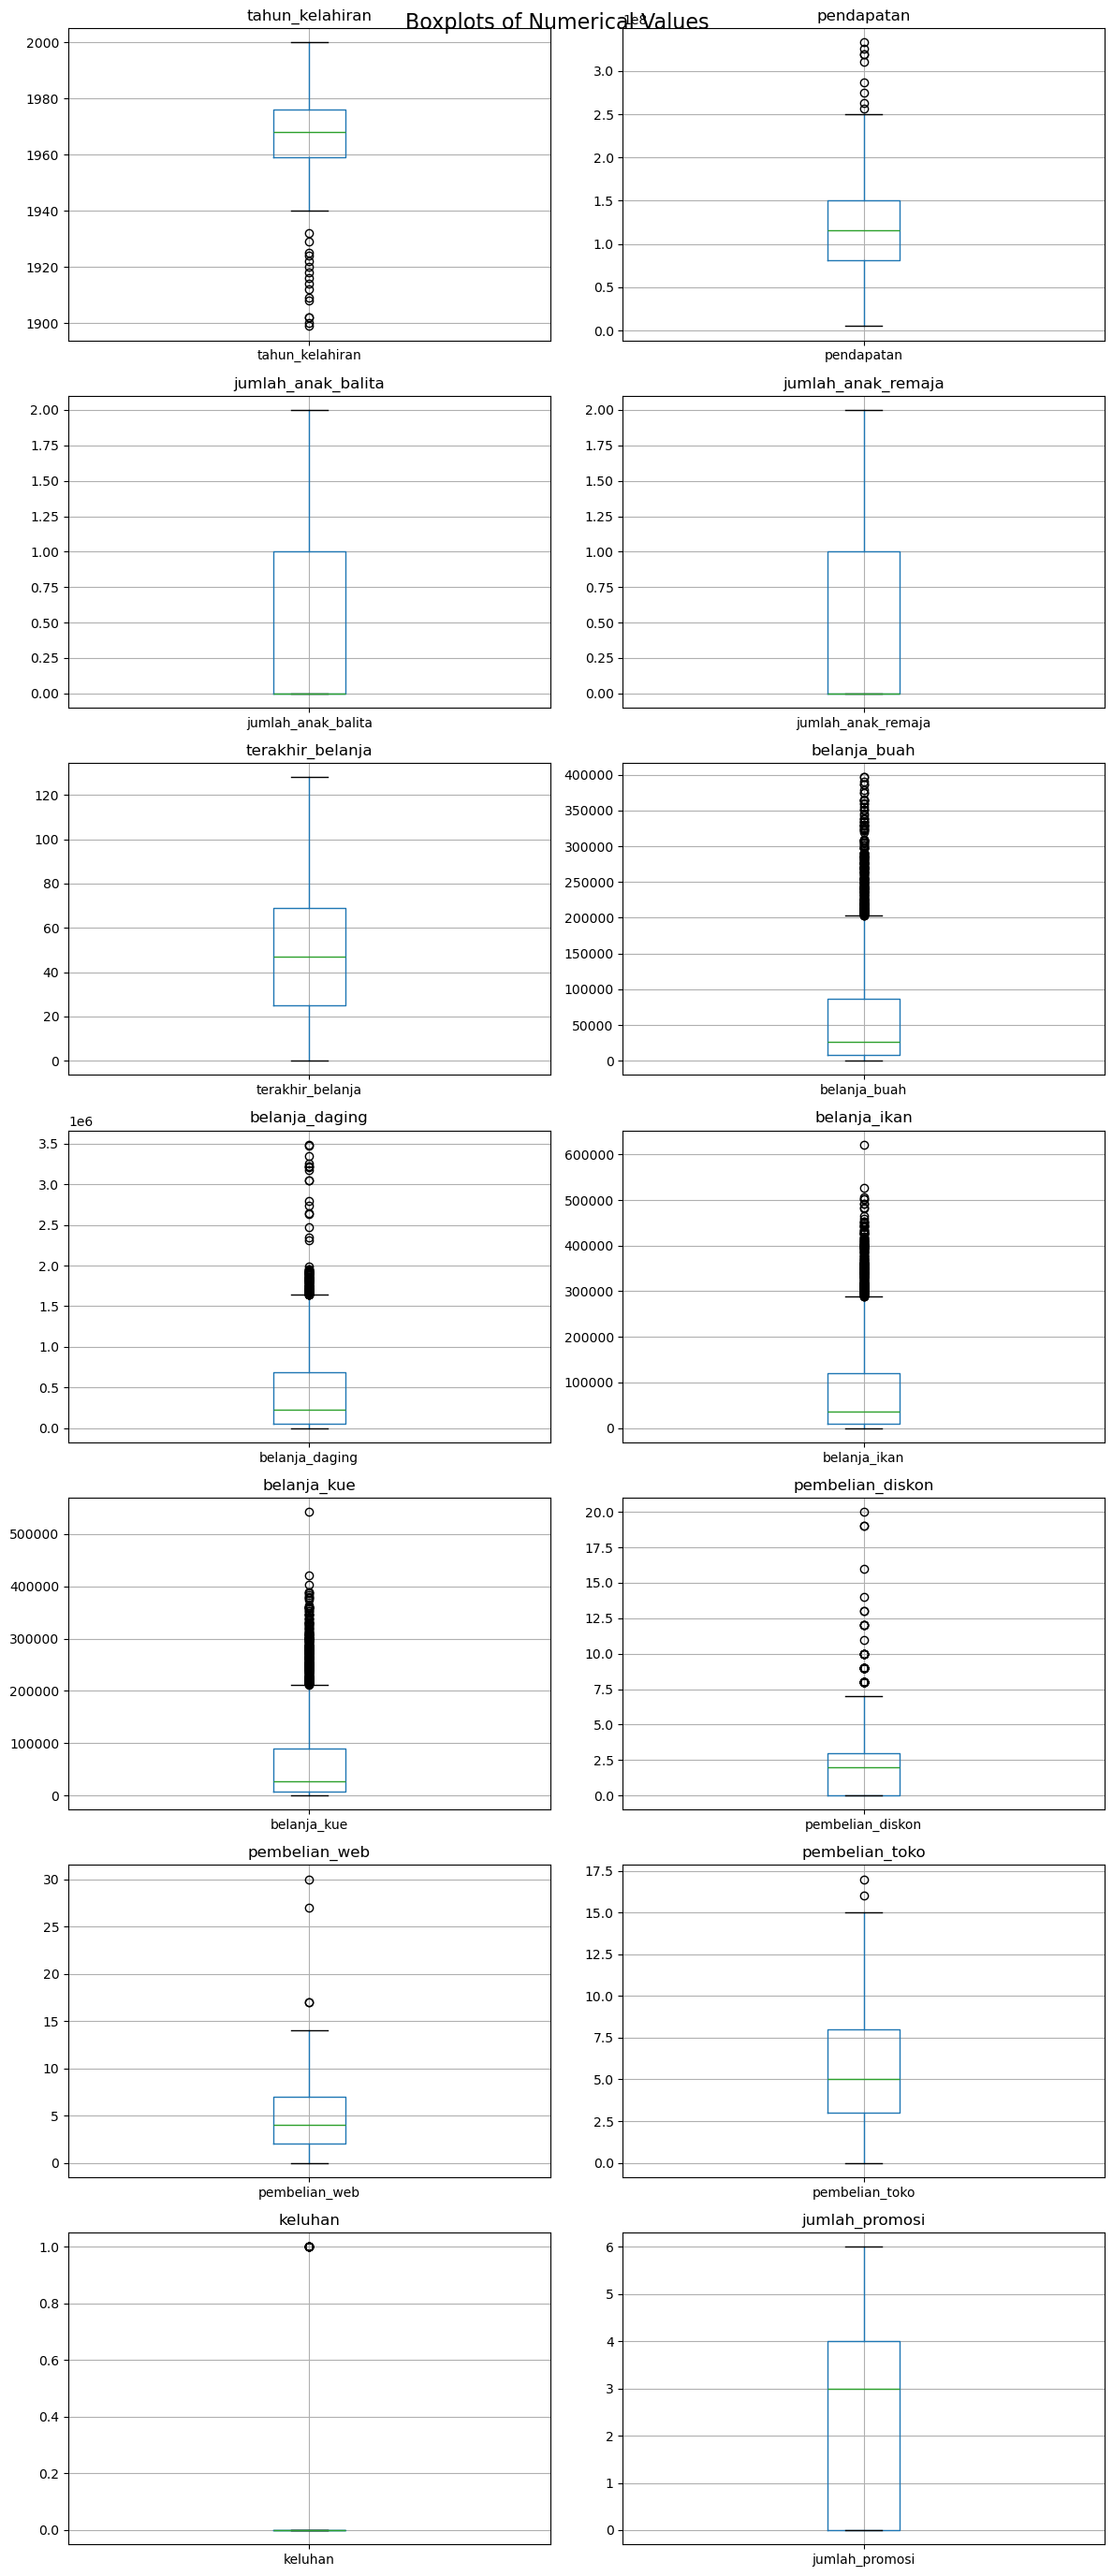

In [83]:
numerical_data = train.select_dtypes(include=[np.number])

num_cols = numerical_data.shape[1]
num_rows = int(np.ceil(num_cols / 2))

fig, axes = plt.subplots(num_rows, 2, figsize=(12, num_rows * 4))
fig.suptitle('Boxplots of Numerical Values', fontsize=16)

for i, column in enumerate(numerical_data.columns):
    ax = axes[i // 2, i % 2] if num_rows > 1 else axes[i % 2]
    numerical_data.boxplot(column=column, ax=ax)
    ax.set_title(column)
    
plt.tight_layout()
plt.show()

In [84]:
def preprocessing(df):
    #
    df = df.drop(['tanggal_menjadi_anggota'], axis=1)
    
    #
    col_int = ['pendapatan','jumlah_anak_balita','jumlah_anak_remaja', 'pembelian_diskon','terakhir_belanja', 'belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue', 'pembelian_web', 'pembelian_toko', 'keluhan']
    for i,col in enumerate(col_int):
        df[col] = df[col].interpolate(method ='pad', limit_direction ='forward')
    df = df.fillna(df.median())

    
    # # Remove the outliers
    # col_out = ['tahun_kelahiran', 'pendapatan', 'pembelian_web', 'pembelian_toko']
    # for i,col in enumerate(col_out):
    #     Q1 = df[col].quantile(0.25)
    #     Q3 = df[col].quantile(0.75)
    #     IQR = Q3 - Q1

    #     lower_bound = Q1 - 1.5 * IQR
    #     upper_bound = Q3 + 1.5 * IQR

    #     df = df[df[col].between(lower_bound, upper_bound)]
    
    #
    
    
    return df

In [85]:
train = preprocessing(train)

C:\Users\User\AppData\Local\Temp\ipykernel_3096\356822798.py:8: FutureWarning: Series.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].interpolate(method ='pad', limit_direction ='forward')


In [86]:
summary(train).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
tahun_kelahiran,int64,0,0,76,1899.000000,2000.000000,1967.823946,11.768131
pendapatan,float64,0,0,3622,5073000.000000,332884000.000000,114502718.265392,43535581.079180
jumlah_anak_balita,float64,0,0,3,0.000000,2.000000,0.294210,0.472682
jumlah_anak_remaja,float64,0,0,3,0.000000,2.000000,0.351061,0.491430
terakhir_belanja,float64,0,0,113,0.000000,128.000000,47.165051,27.038698
belanja_buah,float64,0,0,2535,0.000000,396508.000000,59942.936861,73936.467562
belanja_daging,float64,0,0,2951,0.000000,3489675.000000,437177.892062,510953.244736
belanja_ikan,float64,0,0,2627,0.000000,621600.000000,81472.008908,100224.593805
belanja_kue,float64,0,0,2475,0.000000,542164.000000,62981.860624,78954.662837
pembelian_diskon,float64,0,0,18,0.000000,20.000000,2.126801,2.096382


## Check Correlation

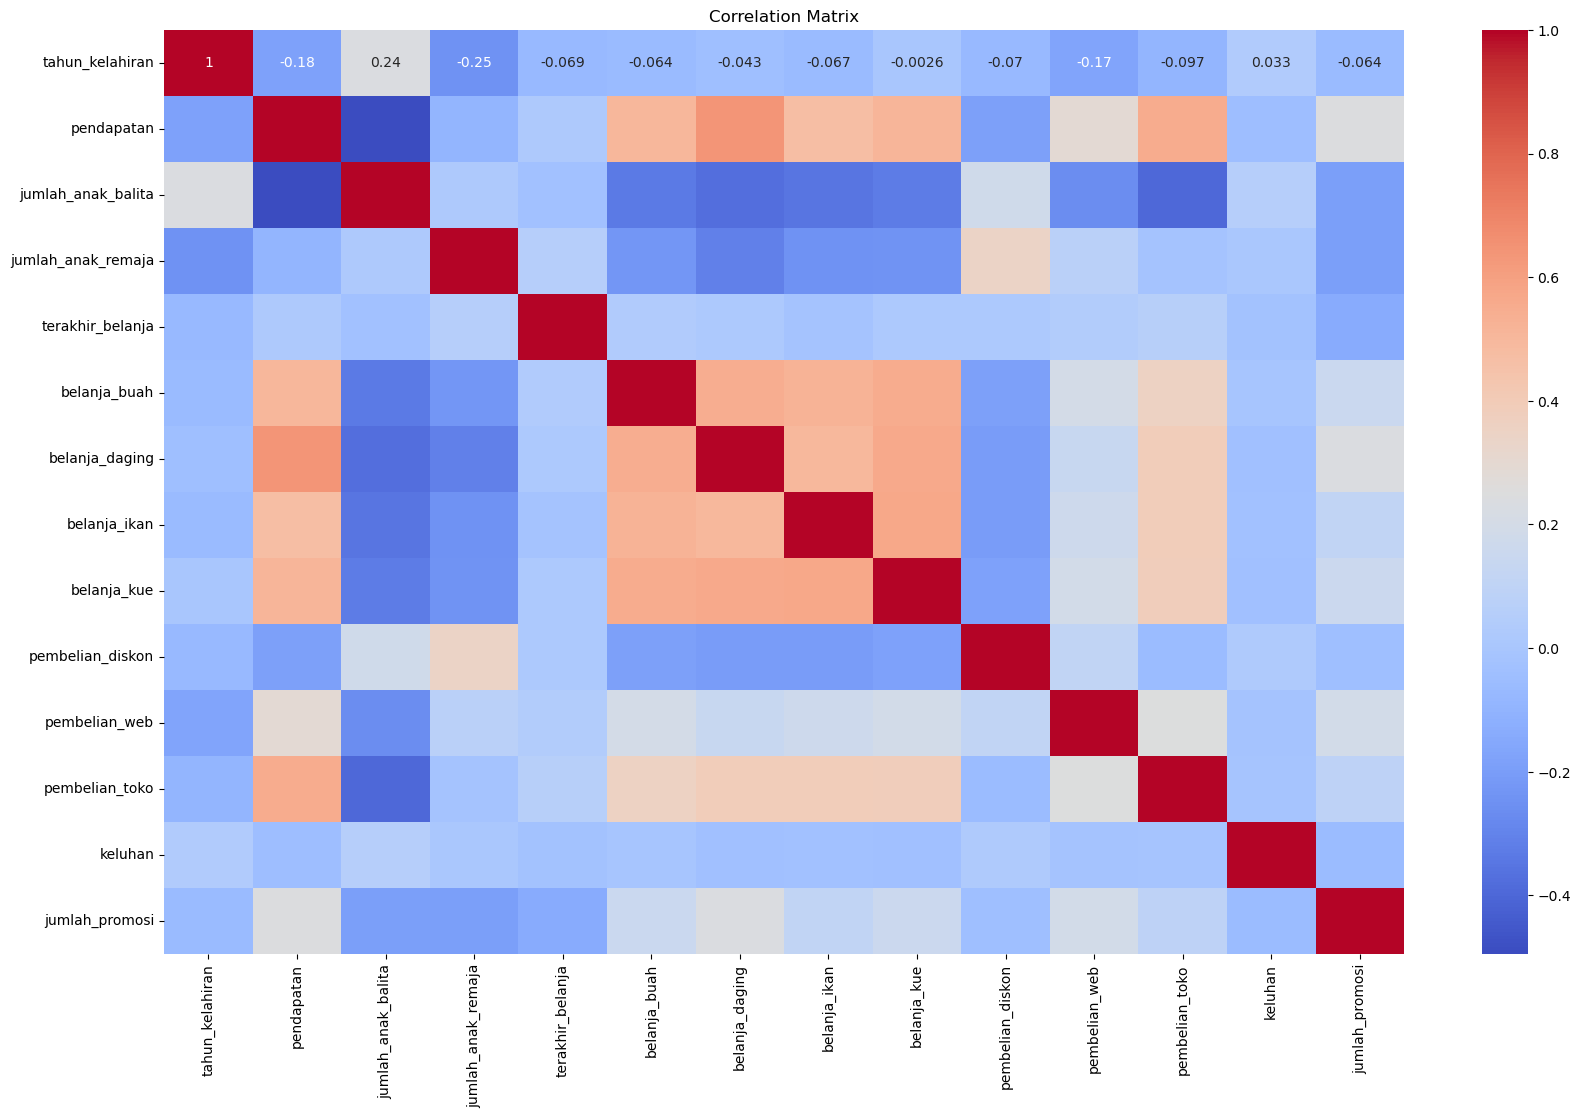

In [115]:
corr_matrix = train.corr()

# Membuat plot heatmap 
plt.figure(figsize=(20,12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.title('Correlation Matrix')
plt.show()

# Model Training

In [88]:
X = train.drop(columns = ['jumlah_promosi'], axis = 1)
y = train['jumlah_promosi']

In [89]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [90]:
# from sklearn.discriminant_analysis import StandardScaler

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_valid = scaler.transform(X_test)

In [91]:
X_train.shape

(3053, 13)

In [92]:
y_train.shape

(3053,)

In [93]:
X_test.shape

(764, 13)

In [94]:
# %%time
# def objective(trial):
#     # Number of trees in random forest
#     c = trial.suggest_float(name="c", low=0, high=1)
    
#     kernel_options = ["linear", "poly", "rbf", "sigmoid"]
#     kernel = trial.suggest_categorical("kernel", kernel_options)
    
#     model = RandomForestClassifier(n_estimators = n_estimators, criterion = 'log_loss', max_depth =  max_depth,
#                                     min_samples_split =  min_samples_split, min_samples_leaf =  min_samples_leaf,
#                                     max_features =  max_features, random_state =  1, n_jobs =  -1)
    
#     score = cross_val_score(model, X_train, y_train, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
#     return score.mean() 

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=42)
# study = optuna.create_study(study_name="random_forest", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=100)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

# '''
# Number of finished trials:  100
# Best trial:
#   Value:  0.7010996707754059
#   Params: 
#     n_estimators: 558
#     max_features: 6
#     max_depth: 59
#     min_samples_split: 2
#     min_samples_leaf: 1
# CPU times: total: 1.91 s
# Wall time: 10min 44s
# '''

In [95]:



# parameters = {
#     'C':            np.arange( 1, 50+1, 1 ).tolist(),
#     'kernel':       ['linear', 'rbf', 'poly', 'sigmoid'],
#     'degree':       np.arange( 0, 50+0, 1 ).tolist(),
#     'gamma':        np.arange( 0.0, 10.0+0.0, 0.1 ).tolist(),
#     'coef0':        np.arange( 0.0, 10.0+0.0, 0.1 ).tolist(),
#     'shrinking':    [True],
#     'probability':  [False],
#     'tol':          np.arange( 0.001, 0.01+0.001, 0.001 ).tolist(),
#     'cache_size':   [2000],
#     'class_weight': [None],
#     'verbose':      [False],
#     'max_iter':     [-1],
#     'random_state': [None],
#     }

# model = RandomizedSearchCV( n_iter              = 2,
#                                         estimator           = SVC(),
#                                         param_distributions = parameters,
#                                         n_jobs              = 4,
#                                         refit               = True,
#                                         cv                  = 10,
#                                         verbose             = 1,
#                                         pre_dispatch        = '2*n_jobs',
#                                         scoring='f1_macro'
#                                         )         # scoring = 'accuracy'
# model.fit(X_train, y_train)
# print( model.best_estimator_ )
# print( model.best_score_ )
# print( model.best_params_ )

In [96]:
from sklearn.model_selection import RepeatedStratifiedKFold

kfold = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 42)

In [97]:
from sklearn.model_selection import cross_val_score


cv = cross_val_score(SVC(),
                        X, y, scoring = 'f1_macro', cv = kfold, n_jobs = -1)
print(f"The average 10-folds Macro F-Score of the RF is {cv.mean()} \n")

The average 10-folds Macro F-Score of the RF is 0.14391671669332115 



### Model 0: Optuna TensorFlow - image classifier (unused, reference only)

In [98]:
# CLASSES = 7
# EPOCHS = 100


# def create_model(trial):
#     # We optimize the numbers of layers, their units and weight decay parameter.
#     n_layers = trial.suggest_int("n_layers", 1, 3)
#     weight_decay = trial.suggest_float("weight_decay", 1e-10, 1e-3, log=True)
#     model = tf.keras.Sequential()
#     model.add(tf.keras.layers.Flatten())
#     for i in range(n_layers):
#         num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 128, log=True)
#         model.add(
#             tf.keras.layers.Dense(
#                 num_hidden,
#                 activation="relu",
#                 kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
#             )
#         )
#     model.add(
#         tf.keras.layers.Dense(CLASSES, kernel_regularizer=tf.keras.regularizers.l2(weight_decay))
#     )
#     return model


# def create_optimizer(trial):
#     # We optimize the choice of optimizers as well as their parameters.
#     kwargs = {}
#     optimizer_options = ["RMSprop", "Adam", "SGD"]
#     optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
#     if optimizer_selected == "RMSprop":
#         kwargs["learning_rate"] = trial.suggest_float(
#             "rmsprop_learning_rate", 1e-5, 1e-1, log=True
#         )
#         kwargs["weight_decay"] = trial.suggest_float("rmsprop_weight_decay", 0.85, 0.99)
#         kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-5, 1e-1, log=True)
#     elif optimizer_selected == "Adam":
#         kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
#     elif optimizer_selected == "SGD":
#         kwargs["learning_rate"] = trial.suggest_float(
#             "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
#         )
#         kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

#     optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
#     return optimizer


# def learn(model, optimizer, pX, pY, mode="eval"):
#     accuracy = tf.metrics.Accuracy("accuracy", dtype=tf.float32)

#     for batch, (features, labels) in enumerate(zip(pX, pY)):
#         with tf.GradientTape() as tape:
#             logits = model(features, training=(mode == "train"))
#             loss_value = tf.reduce_mean(
#                 tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
#             )
#             if mode == "eval":
#                 accuracy(
#                     tf.argmax(logits, axis=1, output_type=tf.int64), tf.cast(labels, tf.int64)
#                 )
#             else:
#                 grads = tape.gradient(loss_value, model.variables)
#                 optimizer.apply_gradients(zip(grads, model.variables))

#     if mode == "eval":
#         return accuracy

# def objective(trial):

#     # Build model and optimizer.
#     model = create_model(trial)
#     optimizer = create_optimizer(trial)

#     # Training and validating cycle.
#     with tf.device("/cpu:0"):
#         for _ in range(EPOCHS):
#             learn(model, optimizer, X_train, y_train, "train")

#         accuracy = learn(model, optimizer, X_test, y_test, "eval")

#     # Return last validation accuracy.
#     return accuracy.result()

# # 3. Create a study object and optimize the objective function.
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

### Model 1: Optuna Tensorflow - Neural Network

In [99]:
# from sklearn.metrics import f1_score

# # Constants
# BATCHSIZE = 128
# CLASSES = 7
# EPOCHS = 1
# N_TRIALS = 100


# def create_model(trial):
#     # We optimize the numbers of layers and their units.
#     n_layers = trial.suggest_int("n_layers", 1, 3)
#     model = Sequential()
#     model.add(Dense(units=trial.suggest_int("n_units_l1", 4, 128, log=True), activation='relu', input_dim=X_train.shape[1]))
#     for i in range(1, n_layers):
#         model.add(Dense(units=trial.suggest_int(f"n_units_l{i+1}", 4, 128, log=True), activation='relu'))
#     model.add(Dense(units=CLASSES, activation='softmax'))
#     return model


# def objective(trial):
#     # Build model
#     model = create_model(trial)
#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#     # Training loop
#     for epoch in range(EPOCHS):
#         model.fit(X_train, y_train, batch_size=BATCHSIZE, epochs=1, verbose=0)

#     # Evaluate model on validation set using Macro F1-Score
#     y_pred = np.argmax(model.predict(X_test), axis=1)
#     score = f1_score(y_test, y_pred, average='macro')
#     return score



# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=N_TRIALS)

# print("Number of finished trials: ", len(study.trials))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: ", trial.value)

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))


### Model 2: Optuna LSTM

In [100]:
# from sklearn.metrics import f1_score
# from tensorflow.keras.layers import LSTM

# # Constants
# BATCHSIZE = 128
# CLASSES = 7
# EPOCHS = 100


# def create_model(trial):
#     # We optimize the number of LSTM units and dropout rate
#     n_units = trial.suggest_int("n_units", 32, 128, log=True)
#     dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)

#     model = Sequential()
#     model.add(LSTM(units=n_units, input_shape=(X_train.shape[1], 1)))
#     for i in range(4):
#         model.add(LSTM(units=trial.suggest_int(f"n_units_l{i+1}", 4, 128, log=True)))
#     model.add(Dense(units=CLASSES, activation='softmax'))

#     return model


# def objective(trial):
#     # Build model
#     model = create_model(trial)
#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#     # Reshape X_train and X_valid for LSTM input (add an additional dimension)
#     X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
#     X_valid_lstm = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], 1)

#     # Training loop
#     model.fit(X_train_lstm, y_train, batch_size=BATCHSIZE, epochs=EPOCHS, verbose=0)

#     # Evaluate model on validation set using Macro F1-Score
#     y_pred = np.argmax(model.predict(X_valid_lstm), axis=1)
#     score = f1_score(y_test, y_pred, average='macro')
#     return score


# if __name__ == "__main__":
#     study = optuna.create_study(direction="maximize")
#     study.optimize(objective, n_trials=30)

#     print("Number of finished trials: ", len(study.trials))

#     print("Best trial:")
#     trial = study.best_trial

#     print("  Value: ", trial.value)

#     print("  Params: ")
#     for key, value in trial.params.items():
#         print("    {}: {}".format(key, value))


In [101]:
# def create_best_model():
#     # Gunakan parameter terbaik yang ditemukan oleh Optuna

#     model = Sequential()
#     model.add(LSTM(units=128, input_shape=(X_train.shape[1], 1)))
#     model.add(Dense(units=CLASSES, activation='softmax'))

#     return model

# # Membuat model terbaik setelah optimisasi
# best_model = create_best_model()

# # def create_best_model(trial):
# #     # Gunakan parameter terbaik yang ditemukan oleh Optuna
# #     n_units = study.best_params["n_units"]
# #     dropout_rate = study.best_params["dropout_rate"]

# #     model = Sequential()
# #     model.add(LSTM(units=n_units, input_shape=(X_train.shape[1], 1)))
# #     model.add(Dense(units=CLASSES, activation='softmax'))

# #     return model

# # # Membuat model terbaik setelah optimisasi
# # best_model = create_best_model(study.best_trial)


In [102]:
# from keras.models import Sequential
# from keras.layers import SpatialDropout1D, LSTM, Dense
# from keras.callbacks import EarlyStopping
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# from sklearn.model_selection import train_test_split
# import numpy as np

# # Assuming X_train, y_train, X_test, y_test are your training and test data

# # Reshape X_train and X_test to include the sequence dimension
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# # Convert y_train and y_test to categorical labels if using 'categorical_crossentropy' loss
# # Use LabelEncoder + OneHotEncoder or to_categorical from Keras utils
# # Example:
# # label_encoder = LabelEncoder()
# # integer_encoded = label_encoder.fit_transform(y_train)
# # y_train = np_utils.to_categorical(integer_encoded)

# y = tf.keras.utils.to_categorical(y, num_classes)

# # Define the model
# model = Sequential()
# model.add(SpatialDropout1D(0.7))
# model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7, return_sequences=True))
# model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7, return_sequences=True))
# model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7, return_sequences=True))
# model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
# model.add(Dense(7, activation='softmax'))

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.F1Score(average='macro')])
# print(model.summary())

# # Train the model
# history = model.fit(X_train, y_train, epochs=100, batch_size=128,
#                     validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0001)])

# # Evaluate the model on test data
# test_loss, test_acc = model.evaluate(X_test, y_test)
# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_acc)


In [103]:
# import tensorflow as tf
# from tensorflow.keras.layers import Dense, LSTM
# from tensorflow.keras.models import Sequential

# # Assuming your data is loaded into NumPy arrays
# # print(X.shape)  # Shape (3817, 8)
# # print(y.shape)  # Shape (3817,) - Target labels (one-hot encoded or integers)

# # Define number of classes (modify based on your actual number of classes)
# num_classes = 7  # Replace with the actual number of classes in your data

# # One-hot encode target labels if they are not already encoded
# y = tf.keras.utils.to_categorical(y, num_classes)

# # Define the model
# model = Sequential([
#   LSTM(128, activation='relu', input_shape=(X.shape[1], 1)),  # Input layer with 8 features
#   LSTM(64, activation='relu'),
#   Dense(7, activation='softmax')  # Output layer with num_classes units
# ])

# # Compile the model
# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy', tf.keras.metrics.F1Score(average='macro')])

# # Train the model (adjust epochs and batch size as needed)
# model.fit(X, y, epochs=150, batch_size=32)

# y_test = tf.keras.utils.to_categorical(y_test, num_classes)
# # Evaluate the model (on separate test data for a more reliable assessment)
# loss, accuracy, f1_macro = model.evaluate(X_test, y_test)
# print('Test Loss:', loss)
# print('Test Accuracy:', accuracy)
# print('Test F1 Macro:', f1_macro)


In [104]:
# from sklearn.model_selection import RepeatedStratifiedKFold

# kfold = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 42)

In [105]:
# for train_index, test_index in kfold.split(X, y):
#     print(train_index)
#     print(test_index)
    
#     # Splitting the data using iloc to access rows by index
#     X_train, X_val = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[test_index]

#     # Convert DataFrame to numpy arrays and reshape if needed (e.g., for LSTM input)
#     X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
#     X_val = np.array(X_val).reshape(X_val.shape[0], X_val.shape[1], 1)

#     # Create the best model based on your optimization
#     model = create_best_model()

#     # Compile the model
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#     # Train the model on this fold
#     model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


In [106]:
# from sklearn.model_selection import KFold

# # Definisikan fungsi untuk cross-validation
# def cross_validation_f1(model, X, y, n_splits=5):
#     kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
#     f1_scores = []
#     for train_index, valid_index in kf.split(X):
#         X_train_cv, X_valid_cv = X[train_index], X[valid_index]
#         y_train_cv, y_valid_cv = y[train_index], y[valid_index]

#         # Reshape X_train_cv dan X_valid_cv untuk LSTM input
#         X_train_cv_lstm = X_train_cv.reshape(X_train_cv.shape[0], X_train_cv.shape[1], 1)
#         X_valid_cv_lstm = X_valid_cv.reshape(X_valid_cv.shape[0], X_valid_cv.shape[1], 1)

#         # Compile dan fit model
#         model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#         model.fit(X_train_cv_lstm, y_train_cv, batch_size=BATCHSIZE, epochs=EPOCHS, verbose=0)

#         # Prediksi dan hitung f1-score pada data validasi
#         y_pred_cv = np.argmax(model.predict(X_valid_cv_lstm), axis=1)
#         f1_scores.append(f1_score(y_valid_cv, y_pred_cv, average='macro'))

#     return np.mean(f1_scores)

# # Lakukan cross-validation untuk menghitung rata-rata F1-Score
# avg_f1_score = cross_validation_f1(best_model, X, y)
# print("Average F1-Score (Cross-Validation):", avg_f1_score)


In [107]:
# # Object to describe the result
# from sklearn.model_selection import cross_val_score

# results = cross_val_score(model, X, y,scoring = 'f1_macro', cv = kfold, n_jobs=-1)
# # Result
# print("Result: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [108]:
# def Model():
#     model = Sequential()
#     model.add(Dense(units=128, activation='relu', input_dim=X_train.shape[1]))
#     model.add(Dense(units=64, activation='relu'))
#     model.add(Dense(units=64, activation='relu'))
#     model.add(Dense(units=64, activation='relu'))
#     model.add(Dense(units=7, activation='softmax'))

#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     model.fit(X_train, y_train, epochs=100)
    
#     return model
#     # model.evaluate(X_test, y_test)

#     # y_pred = np.argmax(model.predict(X_test), axis=1)
#     # score = f1_score(y_test, y_pred, average='macro')

#     # print(score)

In [109]:
# model = Sequential()
# model.add(Dense(units=128, activation='relu', input_dim=X_train.shape[1]))
# model.add(Dense(units=64, activation='relu'))
# model.add(Dense(units=64, activation='relu'))
# model.add(Dense(units=64, activation='relu'))
# model.add(Dense(units=7, activation='softmax'))

# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# # model.fit(X_train, y_train, epochs=100)
    
# # model.evaluate(X_test, y_test)

In [110]:
# from keras.wrappers import KerasClassifier
# estimator = KerasClassifier(build_fn = Model, epochs = 100, batch_size = 10, verbose = 0)

In [111]:
# model = Model()

In [112]:
# from sklearn.model_selection import RepeatedStratifiedKFold

# kfold = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 42)

In [113]:
# # Object to describe the result
# from sklearn.model_selection import cross_val_score

# results = cross_val_score(model, X, y,scoring = 'f1_macro', cv = kfold, n_jobs=-1)
# # Result
# print("Result: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))